# E-commerce Website page A/B Test: 

## table of content
- [Introduction](#intro)
- [Data Preprocessing](#preprocessing)
- [stats calculations](#stats)
- [Part II - A/B Test](#ab_test)
- [conclusion](#conc)

<a id='intro'></a>
## A- Introduction

A/B testing, also known as split testing, is the process of comparing two different versions of a web page or email so as to determine which version generates more conversions.
the results of this test wil help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

## B- Data Preprocessing <a id='preprocessing'></a>

In [28]:
# importing libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

### 1- Loading Website data
there are a total of 5 columns:
<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

In [42]:
#loading the data
df = pd.read_csv('data//ab_data.csv')
df.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


### 2- removing Input errors
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |

Errors:
- Error 1: when the "group" is `treatment` but "landing_page" is not a `new_page`.
- Error 2: when the "group" is `control` but "landing_page" is not a `old_page`.

In [43]:
# number of mismatched treatment-new page
treatment_errors = df[(df.group == 'treatment') & (df.landing_page != 'new_page')]
len(treatment_errors)

1965

In [44]:
# number of mismatched control-old page
control_errors = df[(df.group == 'control') & (df.landing_page != 'old_page')]
len(control_errors)

1928

In [45]:
# totla number of input errors
n_bad_rows= (len(treatment_errors) +len(control_errors))
n_bad_rows

3893

In [46]:
# Removing the inaccurate rows, and store the result in a new dataframe df2
treatment_errors = df[(df.group == 'treatment') & (df.landing_page == 'old_page')]
control_errors = df[(df.group == 'control') & (df.landing_page == 'new_page')]
errors = treatment_errors.append(control_errors)

df2 = df.drop(errors.index, axis = 'index')
df2.head()

C:\Users\Mohimen\AppData\Local\Temp\ipykernel_5724\2398530168.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  errors = treatment_errors.append(control_errors)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [47]:
# Double Check all of the incorrect rows were removed from df2 
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### 3- Removing Nulls

In [48]:
# total number of nulls in each column
df2.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### 4- Removing duplicates

In [64]:
# number of users
print('number of unique users:', df2.user_id.nunique())
# number of duplicates
print('number of users:',df2.user_id.duplicated().sum())
# duplicated usere entries in the data
dup_rows = df2[df2.user_id.duplicated()].index

print('duplicated user_id row index:' , dup_rows)

# remove the duplicates
df2 = df2.drop( dup_rows )
print('\nnumber duplicated user id rows (check):',df2.user_id.duplicated().sum() )

number of unique users: 290584
number of users: 0
duplicated user_id row index: Int64Index([], dtype='int64')

number duplicated user id rows (check): 0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

## Stats <a id= 'stats'></a>

- probability of an individual converting regardless of the page they receive.
- `control` group conversion probability.
- `treatment` group conversion probability.
- differance between old page and new page conversion rate.
- the probability that an individual received the new page.
- experament duration.

__`Note`__
- for an almost equal sample size the control group conversion was slightly more than the treatment group conversion.
- by examining the expiremnt duration, the expirament time was 21 days, the standerd is 7 to 14; however, a the longer the expiremnt goes the better.

In [68]:
# population conversion probability (overall conversion rate)
p_population = df2.converted.mean()
p_population

0.11959708724499628

In [69]:
# control group conversion probability (control conversion rate)
p_old = df2[df2.group == 'control'].converted.mean()
p_old

0.1203863045004612

In [70]:
# treatment group conversion probability (treatment conversion rate)
p_new = df2[df2.group == 'treatment'].converted.mean()
p_new

0.11880806551510564

In [71]:
# differance between old page and new page conversion rate.
obs_diff= p_new - p_old
obs_diff

-0.0015782389853555567

In [18]:
# the probability that an individual received the new page
new_page_count= len(df2[df2.landing_page == 'new_page'].landing_page)
new_page_count/ len(df2)

0.5000636646764286

In [19]:
# experament duration
time = pd.to_datetime(df.timestamp)
max(time) - min(time)

Timedelta('21 days 23:59:49.081927')

<a id='ab_test'></a>
## A/B Test

#### Hypothesis:
Assuming that the new page has a better conversion rate the Hypothesis should be as follows:
   - **$H_0:$** $P_{new}$ - $P_{old}$ <= 0
   - **$H_1:$** $P_{new}$ - $P_{old}$ > 0
   
#### Test:
the user data will be used to conduct the test as follows:
- claculate the number of users for each page
- bootstrap the dataset statistic, `conversion rate differance`, 10,000 times
- simulate the null hypothesis.
- plot the sample distrbution and the observed conversion rate differance
- calculate the p value and conclude the result of the test

### Number of users for every group

In [73]:
# number of users shown the old page
new_page_users = df2[df2.group == 'treatment']
n_new = len(new_page_users)
n_new

145310

In [74]:
# number of users shown the new page
old_page_users = df2[df2.group == 'control']
n_old = len(old_page_users)
n_old

145274

### bootstraping

In [77]:
# Sampling distribution (bootstraping) 

# generate and stores 10k values of the differance in conversion rate
p_diffs = [] 

# generate an array of size 10000 where a value of n is the number of succesful conversions
# with every conversion has a probability p
# dividing the array by n returns the proportion of each sample
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new 
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

p_diffs = np.array(p_diffs)

### Null hypothesis simulation

# null hypothesis test
null_dist = np.random.normal(0,np.std(p_diffs),10000)

### Sample distrbution and observed sample

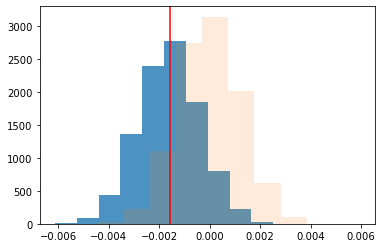

In [79]:
# alternative hypothesis sample distrburion 
# vs null hypothesis sample distrbution

plt.hist(p_diffs, alpha = 0.8)
plt.hist(null_dist, alpha = 0.15)

# sample observed statisitc (differance in conversion proportion)
plt.axvline(obs_diff, color= 'red');

**$H_0:$** $P_{new}$ - $P_{old}$ <= 0

**$H_1:$** $P_{new}$ - $P_{old}$ > 0

### P value and test result

In [33]:
# proportions of values in the Null hypothesis sample distrbution
# greater than the sample observed statistic (p_new - p_old)
P_value_null = (null_dist > obs_diff).mean()
P_value_null

0.9041

## Conclusion <a id = 'conc'></a>
- We fail to reject the null hypothesis
- the old page is preforming better than the new page

In [82]:
df2.to_excel('data//clean_ab_data.xlsx')